In [1]:
import time
import copy
import control
import itertools
import numpy as np
import scipy as sp
import scipy.special as ssp
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('ticks')
rgblist = sns.color_palette('tab10' )

In [2]:
class Cont_gridworld():
    def __init__(self):
        self.d_A = 1
        self.d_S = 2
        
        self.state_space = ([0 for i in range(self.d_S)], [1 for i in range(self.d_S)])
        self.action_space = ([0 for i in range(self.d_A)], [1 for i in range(self.d_A)])
        
        self.state = None
        self.reward = None
        
        self.scaling_factor = self.state_space[1][0] - self.state_space[0][0]
        self.step_size = 0.1
        self.reward_center = np.array([0.8, 0.8])
        self.reward_radii = 0.08
    
    def reset(self):
        self.state = None
        self.reward = None
    
    def init(self):
        self.state = np.zeros((self.d_S))
        return self.state
    
    def step(self, action):
        theta = 2*np.pi*action[0] + np.random.normal(0,0.1)
        self.state = np.clip(self.state + self.step_size*np.array([np.cos(theta), np.sin(theta)]) 
                             + np.random.normal(0,0.1,2), 0, 1)
        
        if np.linalg.norm(self.state - self.reward_center) <= self.reward_radii:
            self.reward = 1
        else:
            self.reward = 0
        return self.state, self.reward
    
    def get_reward(self, sa):
        s = sa[0]
        a = sa[1]
        return (1/2592)*(0.01*((s-6)**4) + s**4) + (1/32)*(0.01*((a-1)**4) + (a+1)**4)

In [3]:
class Cell:
    def __init__(self, start, end, d_S=2, factor=1, parent=None, part_scheme='adapt'):
        self.d = len(start)
        self.d_S = d_S
        self.start = start
        self.end = end
        self.center = [0.5*(start[i]+end[i]) for i in range(self.d)]
        self.factor = factor
        self.diam = (end[0] - start[0])/factor
        self.parent = parent
        self.children = None
        self.part_scheme = part_scheme
        
        if self.part_scheme == 'adapt':
            self.active = True
            if parent is not None:
                for s_child in parent.s_proj.children:
                    if np.equal(self.start[:d_S], s_child.start).all() and np.equal(self.end[:d_S], s_child.end).all():
                        self.s_proj = s_child
                        break
                self.visits = self.parent.visits
                self.visit_times = self.parent.visit_times.copy()
            else:
                self.s_proj = State_cell(self.start, self.end, d_S, part_scheme=part_scheme)
                self.visits = 0
                self.visit_times = []
            self.add_self(self.s_proj)
            
        else:
            self.visits = 0
    
    def remove_self(self, proj):
        for child in proj.children:
            child.corresp_cells.remove(self)
            if child.children is not None:
                self.remove_self(child)
    
    def add_self(self, proj):
        proj.corresp_cells.append(self)
        if proj.children is not None:
            for child in proj.children:
                self.add_self(child)
                
    def get_children(self):
        if self.part_scheme == 'adapt':
            self.active = False
            if self.s_proj.children is None:
                self.s_proj.get_children()
            self.remove_self(self.s_proj)
        
        cells = [[] for i in range(self.d)]
        self.children = []
        for i in range(self.d):
            cells[i].append([self.start[i], self.center[i]])
            cells[i].append([self.center[i], self.end[i]])
        for j in range(2**self.d):
            M = []
            m = bin(j)[2:]
            l_m = len(m)
            if l_m < self.d:
                for l in range(self.d-l_m):
                    m = '0'+m
            for k in range(self.d):
                M.append(int(m[k:k+1]))
            ch = [cells[i][M[i]] for i in range(self.d)]
            start = [ch[i][0] for i in range(self.d)]
            end = [ch[i][1] for i in range(self.d)]
            self.children.append(Cell(start, end, d_S=self.d_S, factor=self.factor, parent=self, 
                                      part_scheme=self.part_scheme))

In [4]:
class State_cell:
    def __init__(self, start, end, d_S=2, parent=None, part_scheme='adapt'):
        self.d_S = d_S
        self.start = start[:d_S]
        self.end = end[:d_S]
        self.center = [0.5*(self.start[i]+self.end[i]) for i in range(self.d_S)]
        self.children = None
        self.parent = parent
        self.part_scheme = part_scheme
        self.corresp_cells = []
        if self.part_scheme == 'adapt' and parent is not None:
            self.corresp_cells = parent.corresp_cells.copy()
        else:
            self.visits = 0
        
    def get_children(self):
        cells = [[] for i in range(self.d_S)]
        self.children = []
        for i in range(self.d_S):
            cells[i].append([self.start[i], self.center[i]])
            cells[i].append([self.center[i], self.end[i]])
        for j in range(2**self.d_S):
            M = []
            m = bin(j)[2:]
            l_m = len(m)
            if l_m < self.d_S:
                for l in range(self.d_S-l_m):
                    m = '0'+m
            for k in range(self.d_S):
                M.append(int(m[k:k+1]))
            ch = [cells[i][M[i]] for i in range(self.d_S)]
            child = {}
            start = [ch[i][0] for i in range(self.d_S)]
            end = [ch[i][1] for i in range(self.d_S)]
            self.children.append(State_cell(start, end, self.d_S, parent=self, part_scheme=self.part_scheme))

In [5]:
def update_partition(point, C, time, partition, s_partition):
    update_flag = False
    update_s_part = False
    cur_cell = find_cell(point,partition)
    if cur_cell is None:
        print(point)
    cur_cell.visits += 1
    cur_cell.visit_times.append(time)
    if cur_cell.visits > C*(cur_cell.diam**(-(d_S+2))):
        update_flag = True
        cur_cell.get_children()
        partition = partition + cur_cell.children
        partition.remove(cur_cell)
        if cur_cell.s_proj in s_partition:
            s_partition.remove(cur_cell.s_proj)
            s_partition = s_partition + cur_cell.s_proj.children
            update_s_part = True
    
    return cur_cell, partition, s_partition, update_flag, update_s_part

In [6]:
def find_cell(point, cells):
    d = len(point)
    for cell in cells:
        skip = False
        for i in range(d):
            if cell.start[i] > point[i] or cell.end[i] < point[i]:
                skip = True
                break
        if skip == False:
            return cell
    return None

In [7]:
def get_eps_cover(eps, env):
    d_S = env.d_S
    d_A = env.d_A
    d = d_S + d_A
    eps_cover = [Cell(env.state_space[0]+env.action_space[0],
                      env.state_space[1]+env.action_space[1],
                      d_S=d_S, factor=env.scaling_factor, part_scheme='fxd'),]
    eps_state_cover = [State_cell(eps_cover[0].start, eps_cover[0].end, d_S=d_S, part_scheme='fxd'),]
    l = np.ceil(np.log2(1/eps)).astype(np.int32)
    covers = [eps_cover,]
    state_covers = [eps_state_cover,]
    for i in range(l):
        state_covers.append([])
        covers.append([])
        for state_cell in state_covers[i]:
            state_cell.get_children()
            state_covers[i+1] = state_covers[i+1] + state_cell.children
        for cell in covers[i]:
            cell.get_children()
            covers[i+1] = covers[i+1] + cell.children
    
    eps_cover = covers[-1]
    eps_state_cover = state_covers[-1]
    
    for cell in eps_cover:
        for s_cell in eps_state_cover:
            if np.equal(cell.start[:d_S], s_cell.start).all() and np.equal(cell.end[:d_S], s_cell.end).all():
                s_cell.corresp_cells.append(cell)
                continue
    return eps_cover, eps_state_cover

In [8]:
def value_iteration(p, r, cover, state_cover):
    V = {}
    for s_cell in state_cover:
        V[s_cell] = 0
    policy = {}
    k = state_cover[-1]
    count = 0
    while True:
        count += 1
        V_old = V.copy()
        for s_cell in state_cover:
            Q = {}
            for cell in s_cell.corresp_cells:
                Q[cell] = r[cell] + sum(p[cell][s_nxt_cell]*V_old[s_nxt_cell] for s_nxt_cell in state_cover)
            V[s_cell] = max(Q.values())
            policy[s_cell] = max(Q, key=Q.get)
        if np.max(abs(np.array(list(V.values())) - np.array(list(V_old.values())))) - np.min(abs(np.array(list(V.values())) - np.array(list(V_old.values())))) < 1e-6:
            break
    return policy, V[k]/count

In [9]:
def evi(p, r, active_cover, state_partition, tol=0.1, conf_coef=10):
    V = {}
    for s_cell in state_partition:
        V[s_cell] = 0
    policy = {}
    k = state_partition[-1]
    count = 0
    while True:
        count += 1
        V_old = V.copy()
        for s_cell in state_partition:
            Q = {}
            for cell in s_cell.corresp_cells:
                conf_rad = conf_coef/max(1,(cell.visits)**(1/(s_cell.d_S+2)))
                Q[cell] = r[cell] + inner_max(p[cell], V_old, conf_rad, state_partition)
            V[s_cell] = max(Q.values())
            policy[s_cell] = max(Q, key=Q.get)
        delta_V = np.array(list(V.values())) - np.array(list(V_old.values()))
        if np.max(delta_V) - np.min(delta_V) < tol:
            break
    return policy

def epe(p, r, state_partition, phi_partition, tol=0.1, conf_coef=10):
    s_lst = state_partition[-1]
    V = {}
    for s_cell in state_partition:
        V[s_cell] = 0
    policy = {}
    k = state_partition[-1]
    count = 0
    while True:
        count += 1
        V_old = V.copy()
        for s_cell in state_partition:
            cell = phi_partition[s_cell]
            conf_rad = conf_coef/max(1,np.sqrt(cell.visits))
            V[s_cell] = r[cell] + inner_max(p[cell], V_old, conf_rad, state_partition)
        if (np.max(abs(np.array(list(V.values())) - np.array(list(V_old.values()))))
        - np.min(abs(np.array(list(V.values())) - np.array(list(V_old.values()))))) < tol*(abs(V[s_lst] - V_old[s_lst])):
            break
    return abs(V[s_lst] - V_old[s_lst])


def inner_max(p, V, conf_rad, state_partition):
    V_sort = dict(sorted(V.items(), key=lambda item: item[1]))
    
    p_ = p.copy()
    
    remain_conf_rad = 0.5*conf_rad
    for s_cell in list(V_sort.keys())[::-1]:
        p_[s_cell] = min(1, p[s_cell] + remain_conf_rad)
        remain_conf_rad -= p_[s_cell] - p[s_cell]
        if remain_conf_rad == 0:
            break
    
    for s_cell in list(V_sort.keys()):
        p_[s_cell] = max(0, 1 - sum(p_.values()) + p_[s_cell])
        if sum(p_.values(), 0.0) == 1:
            break
    
    maximized_expt_reward = 0
    for s_cell in state_partition:
        maximized_expt_reward += p_[s_cell]*V[s_cell]
    
    return maximized_expt_reward

In [10]:
class active_policy_mf:
    def __init__(self, param, key, actv_pols, C_d=1, C_i=1.1):
        self.factor = C_i/C_d
        self.C_d = C_d
        self.key = key
        self.param = param
        self.avg_rew = 0
        self.visits = 0
        self.diam = C_d/np.sqrt(max(self.visits,1))
        self.last_diam = C_d/np.sqrt(max(self.visits,1))
        self.index = self.avg_rew + self.factor*self.diam
        self.neighbors = actv_pols
    
    def update(self, reward):
        self.visits += 1
        self.diam = self.C_d/np.sqrt(self.visits)
        self.avg_rew += (reward - self.avg_rew)/self.visits
        self.index = self.avg_rew + self.factor*self.diam
    
    def update_neighbor(self):
        for neighbor in self.neighbors:
            if self.diam + neighbor.diam < np.linalg.norm(self.param - neighbor.param):
                self.neighbors.remove(neighbor)

class active_policy_mb:
    def __init__(self, param, key, actv_pols, C_d=1, C_i=1.1):
        self.factor = C_i/C_d
        self.C_d = C_d
        self.key = key
        self.param = param
        self.avg_rew = 0
        self.visits = 0
        self.diam = 1
        self.last_diam = 1
        self.index = self.avg_rew + self.factor*self.diam
        self.neighbors = actv_pols
    
    def update(self, reward):
        self.visits += 1
        self.avg_rew += (reward - self.avg_rew)/self.visits
        self.index = self.avg_rew + self.factor*self.diam
    
    def diam_update(self, diam):
        self.diam = diam
    
    def last_diam_update(self):
        self.last_diam = self.diam
    
    def update_neighbor(self):
        for neighbor in self.neighbors:
            if self.diam + neighbor.diam < np.linalg.norm(self.param - neighbor.param):
                self.neighbors.remove(neighbor)

In [11]:
def update_active_policies_mf(actv_pols, key, C_d=5, C_i=10):
    d_w = len(actv_pols[1].param)
    n_pol = len(actv_pols)
    
    if d_w == 3:
        n_r = 5
        n_te = 10
        found_flag = False
        r = actv_pols[key].diam + (actv_pols[key].last_diam - actv_pols[key].diam)*np.linspace(0.1, 1, n_r)
        te = np.linspace(0, 2*np.pi, n_te)
        for x, y, z in itertools.product(r,te,te):
            pt = actv_pols[key].param + x*np.array([np.cos(y)*np.cos(z), np.sin(y)*np.cos(z), np.sin(z)])
            if pt[0] > 0.5 or pt[0] < -0.5 or pt[1] > 0.5 or pt[1] < -0.5 or pt[2] > 1 or pt[2] < 0:
                continue
            pt_covered = False
            for neighbor in actv_pols[key].neighbors.values():
                if np.linalg.norm(pt - neighbor.param) <= neighbor.diam:
                    pt_covered = True
                    break
            if pt_covered == False:
                found_flag = True
                break
    
    if found_flag:
        new_policy = active_policy_mf(pt, n_pol+1, actv_pols, C_d, C_i)
        actv_pols[n_pol+1] = new_policy
    
    return actv_pols, found_flag

def update_active_policies_mb(actv_pols, key, C_d=5, C_i=10):
    d_w = len(actv_pols[1].param)
    n_pol = len(actv_pols)
    
    if d_w == 3:
        n_r = 10
        found_flag = False
        pts_1 = np.linspace(0,1,n_r)
        pts_2 = np.linspace(-0.5,0.5,n_r)
        for x, y, z in itertools.product(pts_2,pts_2,pts_1):
            pt = np.array([x,y,z])
            pt_covered = False
            for key in actv_pols.keys():
                if np.linalg.norm(pt - actv_pols[key].param) <= actv_pols[key].last_diam:
                    pt_covered = True
                    break
            if pt_covered == False:
                new_policy = active_policy_mb(pt, n_pol+1, actv_pols, C_d, C_i)
                actv_pols[n_pol+1] = new_policy
                found_flag = True
        return actv_pols, found_flag

In [12]:
def pzrlmf(env, T, hp, seed, verbose=False):
    d_w = hp[0]
    C_d = hp[1]
    C_i = hp[2]
    n_pol = 1
    
    if d_w == 3:
        param = [np.random.uniform(-1,1), np.random.uniform(-1,1), np.random.uniform(0,1)]
    
    actv_pols = {}
    actv_pols[n_pol] = active_policy_mf(param, n_pol, actv_pols, C_d, C_i)
    
    last_pol = None
    
    h, H_k, k, sum_rewards = 0, 0, 0, 0
    cumul_rewards = []
    np.random.seed(seed)
    next_state = env.init()
    for t in range(T):
        if h == H_k:
            h = 0
            update_flag = False
            if t != 0:
                last_pol_key = policy_key
                last_pol = actv_pols[policy_key]
            ## update the set of active policies
            
            if last_pol is not None and last_pol.diam != last_pol.last_diam:
                actv_pols, update_flag = update_active_policies_mf(actv_pols, last_pol_key, C_d, C_i)
                actv_pols[last_pol_key].update_neighbor
            
            ## compute the indices of the active policies
            
            indices = {pol.key: pol.index for pol in actv_pols.values()}
            policy_key = max(indices, key=indices.get)
            policy_param = actv_pols[policy_key].param
            k += 1
            if verbose:
                print("Episode: {} | Stage: {}".format(k, t+1))
            H_k = max(1,actv_pols[policy_key].visits)
        h += 1
        
        state = next_state.copy()
        if d_w == 3:
            action = np.array([np.minimum(1, np.maximum(0,state[0]*policy_param[0] + state[1]*policy_param[1] 
                                                        + policy_param[2]))])
        next_state, reward = env.step(action)
        actv_pols[policy_key].update(reward)
        sum_rewards += reward
        cumul_rewards.append(sum_rewards)
    return cumul_rewards

In [13]:
def pzrlmb(env, T, hp, seed, verbose=False):
    d_w = hp[0]
    C_d = hp[1]
    C_i = hp[2]
    C_a = 1
    L_r = 0.2
    
    active_cover = [Cell(env.state_space[0]+env.action_space[0], 
                         env.state_space[1]+env.action_space[1],
                         d_S=env.d_S, factor=env.scaling_factor, part_scheme='adapt'),]
    state_partition = [active_cover[0].s_proj,]
    visit_snap = {}
    for cell in active_cover:
        cell.visits = 0
        visit_snap[cell] = 1
    transitions = []
    
    n_pol = 1
    
    if d_w == 3:
        param = [np.random.uniform(-0.5,0.5), np.random.uniform(-0.5,0.5), np.random.uniform(0,1)]
    
    actv_pols = {}
    actv_pols[n_pol] = active_policy_mb(param, n_pol, actv_pols, C_d, C_i)
    
    last_pol = None
    
    h, H_k, k, sum_rewards = 0, 0, 0, 0
    cumul_rewards = []
    np.random.seed(seed)
    next_state = env.init()
    for t in range(T):
        if h == H_k:
            h = 0
            update_flag = False
            if t != 0:
                last_pol_key = policy_key
                last_pol = actv_pols[policy_key]
                
            state_partition_k = state_partition.copy()
            transition_counter = {}
            for cell in active_cover:
                transition_counter[cell] = {}
                for s_cell in state_partition_k:
                    transition_counter[cell][s_cell] = 0
            for cell in active_cover:
                if t-1 in cell.visit_times:
                    cell.visit_times.remove(t-1)
                for i in cell.visit_times:
                    next_cell = find_cell(transitions[i+1][:env.d_S],state_partition_k)
                    transition_counter[cell][next_cell] += 1
            p_hat = {}
            r_hat = {}
            diam = {}
            visit_snap = {}
            for cell in active_cover:
                p_hat[cell] = {k: v / max(1,cell.visits) for k, v in transition_counter[cell].items()}
                r_hat[cell] = env.get_reward(cell.center) + L_r*cell.diam
                diam[cell] = cell.diam
                visit_snap[cell] = max(1,cell.visits)
            if t != 0:
                policy_cells = {}
                diameters = {}
                for key in actv_pols.keys():
                    policy_cells[key] = {}
                    for st_cell in state_partition_k:
                        st = st_cell.center
                        if d_w == 3:
                            acn = np.array([np.minimum(1, np.maximum(0,st[0]*actv_pols[key].param[0]
                                                                     + st[1]*actv_pols[key].param[1]
                                                                     + actv_pols[key].param[2]))])
                        cl = find_cell(np.concatenate((st,acn)), active_cover)
                        policy_cells[key][st_cell] = cl
                    actv_pols[key].diam_update(2*epe(p_hat, diam, state_partition_k, policy_cells[key], 1/np.sqrt(max(t,1)), 1))
                    if key == last_pol_key:
                        actv_pols[key].last_diam_update()
                
                ## update the set of active policies
                actv_pols, update_flag = update_active_policies_mb(actv_pols, last_pol_key, C_d, C_i)
            
            ## compute the indices of the active policies
            
            indices = {pol.key: pol.index for pol in actv_pols.values()}
            policy_key = max(indices, key=indices.get)
            policy_param = actv_pols[policy_key].param
            k += 1
            if verbose:
                print("Episode: {} | Stage: {}".format(k, t+1))
            H_k = max(2,actv_pols[policy_key].visits)
            #print(actv_pols[policy_key].diam, actv_pols[policy_key].last_diam)
        h += 1
        
        state = next_state.copy()
        state_cell = find_cell(state, state_partition_k)
        if d_w == 3:
            action = np.array([np.minimum(1, np.maximum(0,state[0]*policy_param[0] + state[1]*policy_param[1] 
                                                        + policy_param[2]))])
        next_state, reward = env.step(action)
        
        actv_pols[policy_key].update(reward)
        sum_rewards += reward
        cumul_rewards.append(sum_rewards)
        
        sa = np.concatenate((state, action))
        transitions.append(sa)
        
        sa_cell, active_cover, state_partition, update_flag, update_s_part = update_partition(sa, C_a, t, active_cover, state_partition)
    return cumul_rewards

In [14]:
def zorl(env, T, hyperparams, seed, verbose=False):
    C_a = hyperparams[0]                                  # cell activation coefficient
    L_r = hyperparams[1]                                  # bonus coefficient
    C_c = hyperparams[2]                                  # confidence coefficient
    C_H = hyperparams[3]                                  # episode duration parameter
    eps_bd = hyperparams[4]                               # base discretization parameter
    gamma = 0.05
    delta = 0.1
    
    active_cover = [Cell(env.state_space[0]+env.action_space[0], 
                         env.state_space[1]+env.action_space[1],
                         d_S=env.d_S, factor=env.scaling_factor, part_scheme='adapt'),]
    
    state_partition = [active_cover[0].s_proj,]
    
    # The next block will be executed
    max_diam = 1
    now = time.time()
    while max_diam > eps_bd:
        diams = {}
        for cell in active_cover:
            diams[cell] = cell.diam
        max_diam = max(diams.values())
        for cell in active_cover:
            if diams[cell] > eps_bd:
                while cell.visits <= C_a*(cell.diam**(-(d_S+2))):
                    cell.visits += 1
                cell.get_children()
                active_cover = active_cover + cell.children
                active_cover.remove(cell)
                if cell.s_proj in state_partition:
                    state_partition.remove(cell.s_proj)
                    state_partition = state_partition + cell.s_proj.children
    visit_snap = {}
    for cell in active_cover:
        cell.visits = 0
        visit_snap[cell] = 1
    
    state_partition_k = state_partition.copy()
    transitions = []
    episode_start = False
    
    episode_count = 0
    
    sum_rewards = 0
    cumul_rewards = []
    
    h = 0
    
    np.random.seed(seed)
    next_state = env.init()
    for t in range(T):
        if t == 0 or episode_start:
            h = 0
            episode_start = False
            episode_count += 1
            if verbose:
                print("Episode: {} | Stage: {}".format(episode_count, t+1))
            state_partition_k = state_partition.copy()
            transition_counter = {}
            for cell in active_cover:
                transition_counter[cell] = {}
                for s_cell in state_partition:
                    transition_counter[cell][s_cell] = 0
            for cell in active_cover:
                if t-1 in cell.visit_times:
                    cell.visit_times.remove(t-1)
                for i in cell.visit_times:
                    next_cell = find_cell(transitions[i+1][:env.d_S],state_partition)
                    transition_counter[cell][next_cell] += 1
            p_hat = {}
            r_hat = {}
            d_hat = {}
            visit_snap = {}
            for cell in active_cover:
                p_hat[cell] = {k: v / max(1,cell.visits) for k, v in transition_counter[cell].items()}
                r_hat[cell] = env.get_reward(cell.center) + L_r*cell.diam
                d_hat[cell] = cell.diam
                visit_snap[cell] = max(1,cell.visits)
            start = time.time()
            policy = evi(p_hat, r_hat, active_cover, state_partition_k, 1/np.sqrt(max(1,t)), C_c)
            
            policy_cells = {}
            for st_cell in state_partition_k:
                st = st_cell.center
                acn = policy[st_cell].center[env.d_S:]
                stacn = np.concatenate((st, acn))
                cl = find_cell(stacn, active_cover)
                policy_cells[st_cell] = cl
            diam_pol = epe(p_hat, d_hat, state_partition_k, policy_cells, gamma, C_c)
            H = C_H*np.log(T)*(diam_pol**(-2*env.d_S - 2))
        h += 1
        
        state = next_state.copy()
        state_cell = find_cell(state, state_partition_k)
        action = policy[state_cell].center[env.d_S:]
        
        next_state, reward = env.step(action)
        sum_rewards += reward
        cumul_rewards.append(sum_rewards)
        sa = np.concatenate((state, action))
        transitions.append(sa)
        old_active_cover = active_cover.copy()
        sa_cell, active_cover, state_partition, _, _ = update_partition(sa, C_a, t, active_cover, state_partition)
        
        if h >= H: 
            episode_start = True
    return cumul_rewards

In [15]:
M = Cont_gridworld()
d_S = M.d_S
d_A = M.d_A
d = d_S + d_A
T = 4000

### Hyperparameters ###
## PZRL ##
C_d = 1
C_i = 1.2
hp = [3, C_d, C_i]

## ZoRL ##
C_a = 1
L_r = 0.001
C_c = 0.1
C_H = 1e-5
eps_bd = 1

zorl_hps = [C_a, L_r, C_c, C_H, eps_bd]

In [16]:
repeats = 50
expts = ['pmf', 'pmb', 'zorl']
rewards, regrets = {}, {}
colors = {'pmf':rgblist[8], 'pmb':rgblist[6], 'zorl':rgblist[2]}
expt_names = {'pmf':'PZRL-MF', 'pmb':'PZRL-MB', 'zorl':'ZoRL'}
for expt in expts:
    rewards[expt] = np.zeros((repeats, T))
    regrets[expt] = np.zeros((repeats, T))

In [17]:
verbose = False
for run in range(repeats):
    print("Run: ", run+1, end='\r', flush=True)
    for expt in expts:
        start = time.time()
        if expt == 'pmf':
            rewards[expt][run] = pzrlmf(M, T, hp, run, verbose)
        elif expt == 'pmb':
            rewards[expt][run] = pzrlmb(M, T, hp, run, verbose)
        elif expt == 'zorl':
            rewards[expt][run] = zorl(M, T, zorl_hps, run, verbose)

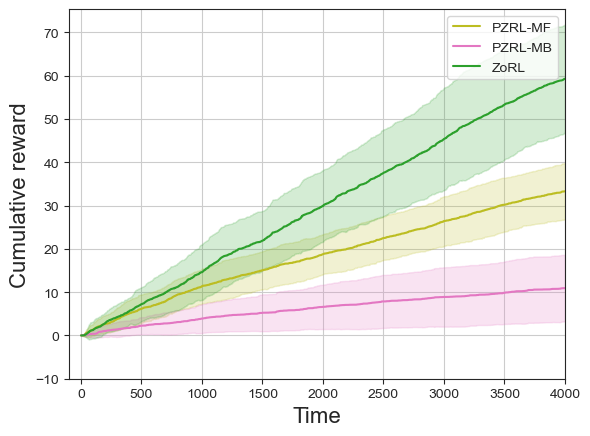

In [18]:
reward_mean, reward_std = {}, {}
for expt in expts:
    reward_mean[expt] = np.mean(rewards[expt],axis=0)
    reward_std[expt] = np.std(rewards[expt],axis=0)
np.save('GriWorld_data.npy', [reward_mean, reward_std])

plt.figure()
plt.tight_layout()
for expt in expts:
    plt.plot(np.arange(1,T+1),reward_mean[expt], color=colors[expt],label=expt_names[expt])
    plt.fill_between(np.arange(1,T+1),reward_mean[expt]-reward_std[expt],
                     reward_mean[expt]+reward_std[expt], color=colors[expt], alpha=0.2)
    plt.legend(fontsize=10,loc='best')
plt.grid()
plt.xlabel('Time',fontsize=16)
plt.ylabel('Cumulative reward',fontsize=16)
plt.xlim(-100,T)
plt.ylim(-10)
plt.savefig("GridWorld_cumul_reward.pdf")